In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time, copy


from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons, make_circles, make_classification, make_blobs
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve


from matplotlib.colors import ListedColormap
cm = plt.cm.RdBu
cm_bright = ListedColormap(["#FF0000", "#0000FF"])


# 

In a Quantum Machine Learning (QML) algorithm, every feature vector $x$ is encoded in the corresponding quantum state (ket) $|x\rangle = L^2$-normalized $x$, to process it with a quantum computer.

In [2]:

def normalize(X):
    norms = np.linalg.norm(X, axis=1)    # each row (example) is 𝐿2-normalized
    X_norm = X/norms.reshape(-1,1) 
    return X_norm


# from sklearn create data for classification

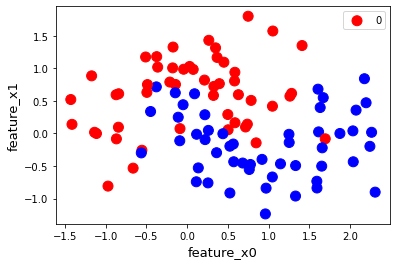

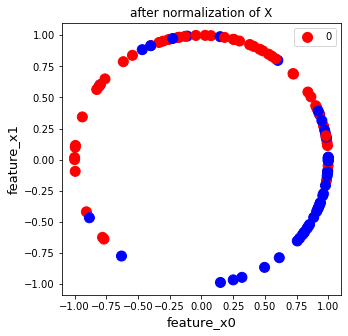

In [3]:
X, Y = make_moons(n_samples=100, noise=0.4, random_state=0)
#X, Y = make_circles(n_samples=200, noise=0.1, random_state=0)
#X, Y = make_blobs(n_samples=200, centers=2, n_features=2, random_state=0)



sct = plt.scatter(X[:,0], X[:,1], s=100, c=Y, marker='o',cmap=cm_bright)  
plt.legend(labels=Y)
plt.xlabel("feature_x0", fontsize=13)
plt.ylabel("feature_x1", fontsize=13)
plt.show()


plt.rcParams["figure.figsize"] = (5,5)
X_norm = normalize(X)
sct = plt.scatter(X_norm[:,0], X_norm[:,1], s=100, c=Y, marker='o',cmap=cm_bright)  
plt.legend(labels=Y)
plt.title('after normalization of X')
plt.xlabel("feature_x0", fontsize=13)
plt.ylabel("feature_x1", fontsize=13)
plt.show()


# Adding new features f2, f3, ...

In [4]:
def adding_more_features(X):
    f0 = X[:, 0] 
    f1 = X[:, 1] 
    f2 = np.power(f0,2) + np.power(f1,2)
    f3 = f0*f1
    f4 = np.ones(X.shape[0])
    f5 = np.power(f0,3) + np.power(f1,3)
    f6 = np.power(f0,2)*f1 + np.power(f1,2)*f0
    f7 = np.power(f0,4) + np.power(f1,4)
    
    #X_new = np.array([f0, f1, f2, f3, f4, f5, f6, f7]).T   # new feature vectors
    X_new = np.array([f0, f1, f2, f3]).T
    return X_new

X_new = adding_more_features(X)


print(np.shape(X_new))

X_new_norm = normalize(X_new)
X_new_norm[0:4] 

(100, 4)


array([[ 0.05338555,  0.70873449,  0.70148755,  0.05254156],
       [ 0.40419689,  0.00329297,  0.91463573,  0.00745098],
       [ 0.74388636, -0.12628855,  0.64750904, -0.10684722],
       [-0.62264417, -0.76642837,  0.14173923,  0.06936705]])

# a layer of single-qubit gates of Quantum Neural Network (QNN)
It is a tensor-product of single-qubit rotations (unitary gates).
The angles of rotations are learnable parameters. 

$\text{R}(\theta) = \cos(\theta) I + \texttt{i}\sin(\theta)\,\sigma $ <br>

$\text{Rs} = \displaystyle\bigotimes_{i} \text{R}(\theta_i)$ where $i$ is the qubit-index.

In [5]:
"Pauli operators = sigma's" 

I2 = np.identity(2)    # single qubit Identity Matrix (gate). Qubit is a 2-level quantum system.

sigma_x = np.array([[0,1],[1,0]])
sigma_y = np.array([[0,-1j],[1j,0]])
sigma_z = np.array([[1,0],[0,-1]])

P0 = np.array([[1,0],[0,0]])   # projector |0><0| 
P1 = np.array([[0,0],[0,1]])   # projector |1><1|


#--------------------------------------------------------------------------------------

" Rotations on each qubit "

def R(theta, sigma): 
    rotation = np.cos(theta)*I2 - 1j*np.sin(theta)*sigma     # single-qubit rotation around sigma by angle theta
    return rotation


def Rs(Theta, sigma):                                  # tensor-product of rotations around sigma for multi qubits
    Rots = R(Theta[0], sigma)                          # Thete is a collection of angles, one for each qubit
    for i in range(1, len(Theta)):                     # number of qubits = len(Thera)
        Rots = np.kron(Rots, R(Theta[i], sigma))
    return Rots



# entangling layer of QNN
It is a tensor-product of two-qubit controlled-Pauli_operators.
This layer will create entanglement between qubits and facilitate quantum information transfer between qubits. This layer carries no learnable parameters.

$\text{CU}_{(i,j)} = |0\rangle_i\langle 0|\otimes I +|1\rangle_i\langle 1|\otimes\sigma_j$ <br>

$\text{CUs} = \displaystyle\bigotimes_{(i,j)} \text{CU}_{(i,j)}$ where $(i,j)$ represents the pair of control and target qubits $i$ and $j$, respectively.

In [6]:
"Control_Us = Control_sigma between each qubit-pair"

def operator0(v):         # v in {0,1,2} will select different items in the sum
    op0 = I2*(1-v)*(2-v)/2 + P0*v*(2-v) + I2*v*(v-1)/2
    return op0

def operator1(v, sigma):   # v in {0,1,2}
    op1 = I2*(1-v)*(2-v)/2 + P1*v*(2-v) + sigma*v*(v-1)/2
    return op1


for v in range(3): print(f'for v={v}:', [(1-v)*(2-v)/2 , v*(2-v) ,v*(v-1)/2])


#--------------------------------------------------------------------------------------

def Control_Us(n_qubit, sigma):
    CUs = np.identity(np.power(2, n_qubit))     # dim = np.power(2, n_qubit)
    for i in range(n_qubit):                    # for each (i,j) pair
        for j in range(i+1, n_qubit):
            one_zero_n = np.zeros(n_qubit)
            one_zero_n[i]=1   # control qubit i set to 1
            one_zero_n[j]=2   # target qubit j set to 2 and the rest are 0
            
            CU0 = operator0(one_zero_n[0])
            CU1 = operator1(one_zero_n[0], sigma)
            for k in range(n_qubit-1):
                CU0 = np.kron(CU0, operator0(one_zero_n[k+1]))
                CU1 = np.kron(CU1, operator1(one_zero_n[k+1], sigma))
            CU = CU0 + CU1
            #print(CU)
            CUs = CUs @ CU
    return CUs                                  # = tensor-product of two-qubit controlled_Unitaries
            


Control_Us(3, sigma_z)        


for v=0: [1.0, 0, 0.0]
for v=1: [0.0, 1, 0.0]
for v=2: [0.0, 0, 1.0]


array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0., -1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0., -1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., -1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -1.]])

# QNN = parameterized quantum circuit


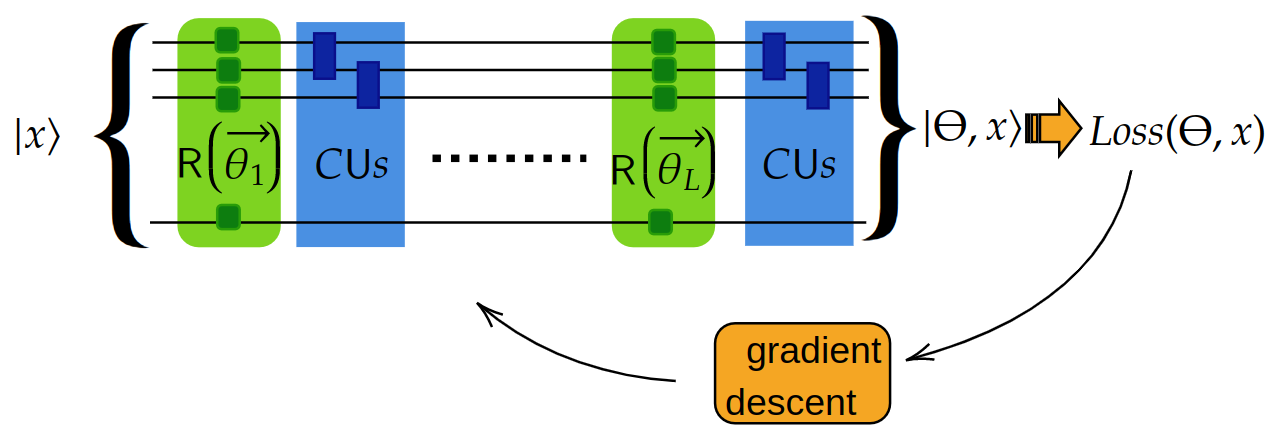

for details see https://iopscience.iop.org/article/10.1088/2058-9565/ab4eb5

In [7]:
n_feature = X_new.shape[1]             

n_qubit = int(np.log2(n_feature))    
dim = np.power(2, n_qubit)           # = dimention of a n-qubit Hilbert space 

n_layer = 3              
n_ang = n_qubit*n_layer 


print("number of features = ", n_feature)
print("number of qubits = ", n_qubit)
print("number of layers = ", n_layer)
print("number of angles (parameters) = ", n_ang)

#--------------------------------------------------------------------------------------

CUs = Control_Us(n_qubit, sigma_x)


'Total_U = complete parameterized quantum circuits(QNN) with all the layers'
def Total_U(Theta, CUs): 
    Theta = np.reshape(Theta, (n_layer, n_qubit))
    TU = CUs @ Rs(Theta[0], sigma_y)
    for ll in range(n_layer-1):
        TU = TU @ CUs @ Rs(Theta[ll+1], sigma_y)
    return TU



def probabilities(X, Theta):
    rot_X = Total_U(Theta, CUs) @ X.T               # X after rotations by the angles=Theta, its shape = (dim x n_example)
    prob_0 = np.power(np.abs(rot_X[0]), 2)          # probabilities of getting |0><0| outcome
    return prob_0



number of features =  4
number of qubits =  2
number of layers =  3
number of angles (parameters) =  6


# parameter (angle) initialization for gradient descent

In [8]:

Theta_in = 0.0001*(np.random.rand(n_ang)-0.5)   # angles for Unitary(Theta) 

print(f'initialial angles for {n_layer} layers = {Theta_in}\n')


initialial angles for 3 layers = [-1.80948235e-06 -1.48658991e-05  2.85111399e-05  2.56275578e-05
  4.06722871e-05  3.22709019e-05]



# train_test_split

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X_new_norm, Y, test_size=0.3, random_state=0)

print(X_new_norm.shape, X_train.shape, X_test.shape)

(100, 4) (70, 4) (30, 4)


#  QNN training ...

For $k$th example, $p_k=|\langle 0|\Theta\rangle|^2$ is the probability of getting $|0\rangle\langle0|$ outcome and $y_k$ is the true label.

$\displaystyle L = -\frac{1}{\text{n_train}}\sum_{k} [y_k\ln(p_k) + (1-y_k)\ln(1-p_k)]$ is the cross-entropy Loss.


$\displaystyle \frac{dL}{d\theta_l} = 
-\frac{1}{\text{n_train}}\sum_{k} \frac{y_k - p_k}{p_k(1-p_k)}\, \frac{dp_k}{d\theta_l}\quad$
where $\displaystyle\frac{dp_k}{d\theta_l}= p_k(\theta_l+\pi/4) - p_k(\theta_l-\pi/4)$ by the parameter shift rule (given in https://arxiv.org/abs/1803.00745 and https://arxiv.org/abs/1811.11184) for $l$th parameter (angle).
Below, loss minimization is done using gradient descent, which is executed by the parameter shift rule.

$ $

In [10]:
'''Iterations start here for gradient descent (GD)'''

time_start = time.time()  # start the stopwatch

Itrs  = 50
alpha = 0.05              # gradient descent step size


#--------------Initialization----------------------

ANGs = [Theta_in]                # Iteration vs sequence of solution-angles
LOSS = [ ]                       # Iteration vs Total loss 

#---------------------------------------------------

for itr in range(Itrs):                   # itr = 0,1,2,...,(Itrs-1)
    
    n_train = X_train.shape[0]            # number of training examples
    
    Theta = ANGs[-1]
    prob_0 = probabilities(X_train, Theta)                   # probabilities of getting |0><0| outcome for all training examples
    loss = -( Y_train @ np.log(prob_0) + (1-Y_train) @ np.log(1-prob_0) )/n_train
    LOSS.append(loss)                                       # append averaged loss before update
    
    grad_0 = -(Y_train - prob_0)/(prob_0*(1-prob_0))
    
#---------------------------------------------------    
                                       
    grad = np.zeros(n_ang)
    for l in range(n_ang):                                  # derivative of loss with respect to lth parameter (angle) = grad[l]                         
        Theta_plus = copy.deepcopy(Theta)
        Theta_plus[l] = Theta_plus[l] + np.pi/4             # parameter shift by + pi/4
        prob_0_plus = probabilities(X_train, Theta_plus)
        
        Theta_minus = copy.deepcopy(Theta)
        Theta_minus[l] = Theta_minus[l] - np.pi/4           # parameter shift by - pi/4
        prob_0_minus = probabilities(X_train, Theta_minus)
        
        grad[l] = grad_0 @ (prob_0_plus - prob_0_minus)     # = dL/d thete_l by the parameter shift rule
    
#---------------------------------------------------    

    Theta = Theta - alpha*(1/n_train)*grad
    ANGs.append(Theta)                                      # append angles after update
    #print(t)
    
    #-----------------------------------------------------------------------------
    
    if itr % 10 == 0: 
        print(f'iteration = {itr}, loss = {round(loss,3)}')
        
    #-----------------------------------------------------------------------------

                              
time_taken = time.time() - time_start                    # stop the stopwatch 
print("time taken in sec. = ", time_taken)


#print(Engs)
#print(ANGs)


iteration = 0, loss = 0.999
iteration = 10, loss = 0.592
iteration = 20, loss = 0.586
iteration = 30, loss = 0.586
iteration = 40, loss = 0.586
time taken in sec. =  0.11390304565429688


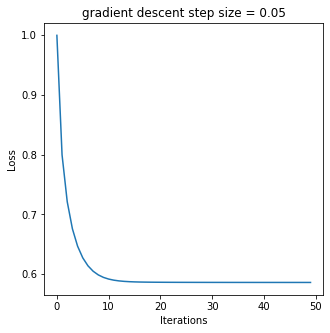

minimum loss = 0.5859808650831176


In [11]:
plt.plot(LOSS)
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.title(f"gradient descent step size = {alpha}")
plt.show()


#print('LOSS =',np.round(LOSS,2),'\n')
#print(len(LOSS), np.array(ANGs).shape)

#-------------------------------------------------------------------------------------

min_loss = np.min(LOSS)                    # minimum loss
pos_min_loss  = np.where(LOSS==min_loss)   # Iteration corresponding to minimum loss
pos_min_loss1 = pos_min_loss[0][0]         # 1st position

print("minimum loss = " +str(min_loss))

ang_sol = ANGs[pos_min_loss1]              # angles corresponding to minimum loss



In [12]:
def accuracy(Y, prob_0, threshold=0.5):
    Y_prediction = np.heaviside(prob_0 - threshold, 1)    # = 0 if prob_0 - threshold <0 , 1 otherwise
    errors = np.abs(Y - Y_prediction)                     #  actual - predicted labels
    acc = 1 - np.mean(errors)                             
    return acc
            

#-------------------------------------------------------------------------------------------
    
prob_0 = probabilities(X_train, ang_sol)
acc = accuracy(Y_train, prob_0, threshold=0.5)
acc

0.7714285714285715

# selecting optimal threshold value

How to choose an optimal threshold value? <br>
Such a choice must depend on domain knowledge. <br>
However, here we choose the threshold that gives the maximum test accuracy.

In [13]:
THRESHOLDs = np.arange(0, 1.01, 0.01)

def threshold_acc(Y, prob_0):
    ACC = []
    for threshold in THRESHOLDs:
        acc = accuracy(Y, prob_0, threshold)
        ACC.append(acc)
    return np.array(ACC)
        

pos_max_acc = [18 39 44 45 46 47 48]
optimal threshold = 0.48

Train accuracy = 0.8
Test accuracy = 0.8



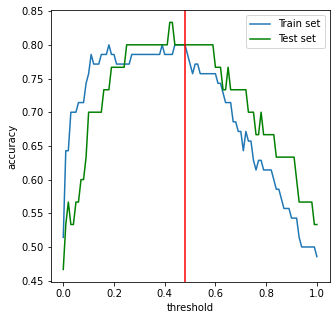

In [14]:
prob_0 = probabilities(X_train, ang_sol)
ACC = threshold_acc(Y_train, prob_0)

max_acc = np.max(ACC)
pos_max_acc = np.where(ACC==max_acc)[0]
arg_max_acc = pos_max_acc[-1]                    # selecting the last one
threshold_opt = THRESHOLDs[arg_max_acc]
print(f'pos_max_acc = {pos_max_acc}')
print(f'optimal threshold = {round(threshold_opt,2)}\n')
    
print(f'Train accuracy = {round(max_acc,2)}')
#print(accuracy(Y_train, prob_0, threshold_opt)==max_acc)

#-----------------------------------------------------------------------------------

prob_0_test = probabilities(X_test, ang_sol)
test_acc = accuracy(Y_test, prob_0_test, threshold_opt) # corresponds to the obtained threshold_opt
print(f'Test accuracy = {test_acc}\n')

#-----------------------------------------------------------------------------------

plt.plot(THRESHOLDs, ACC, label='Train set')
plt.plot(THRESHOLDs, threshold_acc(Y_test, probabilities(X_test, ang_sol)), color='green', label='Test set')
plt.xlabel('threshold')
plt.ylabel('accuracy')
plt.legend()
plt.axvline(x=threshold_opt, color='red')
plt.show()



# Receiver Operating Characteristic (ROC) curve

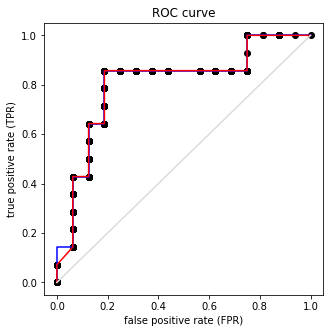

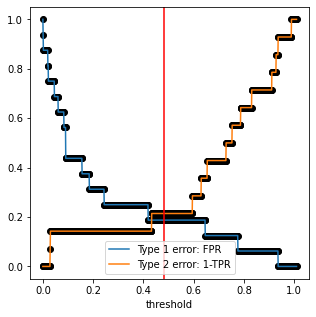

In [15]:

prob_0_test = probabilities(X_test, ang_sol)
p = Y_test.sum()  # number of positives for class=1


thresholds = np.arange(0, 1.01, 0.001)


TPR_FPR = [] # true positive rate (TPR) and false positive rate (FPR) for different thresholds
for threshold in thresholds:
    Y_prediction = np.heaviside(prob_0_test - threshold, 1)    # = 0 if prob_0 - threshold <0 , 1 otherwise
    tn, fp, fn, tp = confusion_matrix(Y_test, Y_prediction).ravel()
    TPR_FPR.append([tp/p, fp/(X_test.shape[0]-p), threshold])
    
#print(thresholds)
#print(TPR_FPR)

TPR_FPR = np.array(TPR_FPR)
TPR, FPR = TPR_FPR[:,0], TPR_FPR[:,1]

#----------------------roc_curve with sklearn--------------------------
fpr, tpr, _ = roc_curve(Y_test, prob_0_test)
plt.plot(fpr, tpr, color='blue')
#---------------------------------------------------------------------


plt.plot(FPR, TPR, color='red')
plt.scatter(FPR, TPR, color='black')
plt.plot(FPR, FPR, color='gainsboro')
plt.title('ROC curve')
plt.xlabel('false positive rate (FPR)')
plt.ylabel('true positive rate (TPR)')
plt.show()


plt.plot(thresholds, FPR, label='Type 1 error: FPR')
plt.scatter(thresholds, FPR, color='black')
plt.plot(thresholds, 1-TPR, label='Type 2 error: 1-TPR')
plt.scatter(thresholds, 1-TPR, color='black')
plt.axvline(x=threshold_opt, color='red')
plt.xlabel('threshold')
plt.legend()
plt.show()